
# BERT to recognise Named Entity Recognition

- Extracting data from a news website
- Use BERT to recognise Named Entity Recognition (NER)
- Plot total number of each NER
- Plot most frequent NER

In [408]:
import requests, re, json
from lxml import html
from bs4 import BeautifulSoup

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import date
from wordcloud import WordCloud

from transformers import pipeline

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Get News on BBC website

In [385]:
def retrieve_page(url):
    # Send a request to the website
    response = requests.get(url)

    # Check if the request was successful
    if response.status_code != 200:
        #print(f"Failed to retrieve the page, Status code: {response.status_code} \n")
        return response
    else:
        #print('Succeed in retrieving the page \n')
        return response

In [388]:
def get_info_from_BBC_url(url):
    response = retrieve_page(url)
    if response.status_code != 200:
        return None
    
    try:
        # Parse the page content
        soup = BeautifulSoup(response.content, 'html.parser')

        # Find the <script> tag with type "application/ld+json"
        json_script = soup.find('script', type='application/ld+json')
        json_script = json.loads(json_script.string)
    
        date = json_script.get('datePublished')
        date = datetime.strptime(date, '%Y-%m-%dT%H:%M:%S.%fZ')
        date = date.strftime('%Y-%m-%d')

        date_obj = pd.to_datetime(date)
        month_year = date_obj.strftime("%B %Y")
        
        # get article
        article = soup.find_all('article')[0]
        title = article.find('h1').get_text(strip=True)

        #text = article.get_text(strip=True)
        #content = " ".join(text.split("\"")[:-1]) if text else None

        content = [p.get_text(strip=True) for p in article.find_all('p')]
        content = ' '.join(content)

        articles_info = {'date': date, 'month': month_year, 'title': title, 'url': url, 'content': content}
        return articles_info

    except Exception as e:
        print('Error in retrieving infos')
        return None

In [389]:
links = [
    "https://www.bbc.com/news/articles/cyv3pzm4178o", "https://www.bbc.com/news/articles/c6273139ed4o", "https://www.bbc.com/news/articles/czen5y97yjzo",
    "https://www.bbc.com/news/articles/cj4v0rey0jzo", "https://www.bbc.com/news/articles/cn42nn3mpxno", "https://www.bbc.com/news/articles/c5ymed4j4epo",
    "https://www.bbc.com/news/articles/c624r7ywn0yo", "https://www.bbc.com/news/articles/cdx9x4l343qo"
]

In [390]:
articles = []
for url in links:
    article = get_info_from_BBC_url(url)
    articles.append(article)

In [391]:
df = pd.DataFrame(articles)
print(df.shape)
df.head()

(8, 5)


,date,month,title,url,content
0,2024-12-02,December 2024,Musk's record $56bn pay deal rejected for seco...,https://www.bbc.com/news/articles/cyv3pzm4178o,Tesla chief executive Elon Musk's record-break...
1,2024-12-02,December 2024,Israel strikes Lebanon as Hezbollah targets mi...,https://www.bbc.com/news/articles/c6273139ed4o,Israel said it struck targets in Lebanon on Mo...
2,2024-12-03,December 2024,Stunning or rubbish? Jaguar's new concept car ...,https://www.bbc.com/news/articles/czen5y97yjzo,Luxury car maker Jaguar has unveiled its new e...
3,2024-11-19,November 2024,Putin approves changes to Russia's nuclear doc...,https://www.bbc.com/news/articles/cj4v0rey0jzo,Vladimir Putin has approved changes to Russia’...
4,2024-11-24,November 2024,Town exploring arts options after theatre closed,https://www.bbc.com/news/articles/cn42nn3mpxno,A council has said it is exploring options to ...


# Named Entity Recognition (NER)

____

**Score: The score the probability that the model assigns to the identified entity being correct**

## Difficulties

**The 2 models give different results because they were trained differently**

___

Model `dslim/bert-base-NER`
- The model uses B-I-O tagging (Begin, Inside, Outside), which is more granular and assigns labels to individual tokens
- The model was fine-tuned for token-level classification
- Some words are masked with ##, maybe because of the tokenization process used by the BERT model


| Abbreviation | Description                                                                 |
|--------------|-----------------------------------------------------------------------------|
| O            | Outside of a named entity                                                    |
| B-MISC       | Beginning of a miscellaneous entity right after another miscellaneous entity |
| I-MISC       | Miscellaneous entity                                                         |
| B-PER        | Beginning of a person’s name right after another person’s name               |
| I-PER        | Person’s name                                                                |
| B-ORG        | Beginning of an organization right after another organization                |
| I-ORG        | Organization                                                                 |
| B-LOC        | Beginning of a location right after another location                         |
| I-LOC        | Location                                                                     |


____


Model `dbmdz/bert-large-cased-finetuned-conll03-english`
- The model uses a grouped entity approach, returning a single label for an entire entity
- Fine-tuned for more standard entity grouping


| Abbreviation | Description                                                                      |
|--------------|----------------------------------------------------------------------------------|
| PER       | Person  |
| ORG      | Organisation                                                          |
| LOC            |  Location


In [444]:
pipe = pipeline("ner", model="dslim/bert-base-NER")
pipe("My name is Taoufiq I work for BNP Paribas in Paris")

Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


[{'entity': 'B-PER',
  'score': 0.9909895,
  'index': 4,
  'word': 'Tao',
  'start': 11,
  'end': 14},
 {'entity': 'I-PER',
  'score': 0.80639786,
  'index': 5,
  'word': '##uf',
  'start': 14,
  'end': 16},
 {'entity': 'B-PER',
  'score': 0.5454969,
  'index': 6,
  'word': '##iq',
  'start': 16,
  'end': 18},
 {'entity': 'B-ORG',
  'score': 0.999353,
  'index': 10,
  'word': 'B',
  'start': 30,
  'end': 31},
 {'entity': 'I-ORG',
  'score': 0.9977754,
  'index': 11,
  'word': '##NP',
  'start': 31,
  'end': 33},
 {'entity': 'I-ORG',
  'score': 0.99925476,
  'index': 12,
  'word': 'Pa',
  'start': 34,
  'end': 36},
 {'entity': 'I-ORG',
  'score': 0.998055,
  'index': 13,
  'word': '##ri',
  'start': 36,
  'end': 38},
 {'entity': 'I-ORG',
  'score': 0.9990459,
  'index': 14,
  'word': '##bas',
  'start': 38,
  'end': 41},
 {'entity': 'B-LOC',
  'score': 0.99952054,
  'index': 16,
  'word': 'Paris',
  'start': 45,
  'end': 50}]

In [188]:
pipe2 = pipeline("ner", model="dbmdz/bert-large-cased-finetuned-conll03-english", grouped_entities=True)
pipe2("My name is Taoufiq I work for BNP Paribas in Paris")

Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


[{'entity_group': 'PER',
  'score': 0.94987917,
  'word': 'Taoufiq',
  'start': 11,
  'end': 18},
 {'entity_group': 'ORG',
  'score': 0.998261,
  'word': 'BNP Paribas',
  'start': 30,
  'end': 41},
 {'entity_group': 'LOC',
  'score': 0.9980166,
  'word': 'Paris',
  'start': 45,
  'end': 50}]

In [392]:
def clean_ner_output(entities):
    cleaned_entities = []
    for entity in entities:
        word = entity['word']
        if word.startswith('##'):
            cleaned_entities[-1]['word'] += word[2:]  
        else:
            cleaned_entities.append(entity)
    return cleaned_entities

In [393]:
def keep_entities(text, pipe):
    ner = pipe(text)

    # Filter for organization, person, and location entities
    entities = [e for e in ner if e['entity_group'].startswith(('PER', 'LOC', 'ORG'))]
    cleaned_entities = clean_ner_output(entities)
    return cleaned_entities

In [394]:
def get_entities(dff, pipe):
    df = dff.copy()
    # Get entities for each news
    df["entity"] = df["content"].apply(lambda x: keep_entities(x, pipe2))

    # Split of line for each entity
    df = df.explode("entity", ignore_index=True)

    # Get Entity Type, Word, Score for each entity
    df['word'] = df['entity'].apply(lambda dico: dico['word'])
    df['score'] = df['entity'].apply(lambda dico: dico['score'])
    df['entity_group'] = df['entity'].apply(lambda dico: dico['entity_group'])
    return df

In [395]:
df = get_entities(df, pipe)
df.head()

,date,month,title,url,content,entity,word,score,entity_group
0,2024-12-02,December 2024,Musk's record $56bn pay deal rejected for seco...,https://www.bbc.com/news/articles/cyv3pzm4178o,Tesla chief executive Elon Musk's record-break...,"{'entity_group': 'ORG', 'score': 0.9975991, 'w...",Tesla,0.997599,ORG
1,2024-12-02,December 2024,Musk's record $56bn pay deal rejected for seco...,https://www.bbc.com/news/articles/cyv3pzm4178o,Tesla chief executive Elon Musk's record-break...,"{'entity_group': 'PER', 'score': 0.99855447, '...",Elon Musk,0.998554,PER
2,2024-12-02,December 2024,Musk's record $56bn pay deal rejected for seco...,https://www.bbc.com/news/articles/cyv3pzm4178o,Tesla chief executive Elon Musk's record-break...,"{'entity_group': 'LOC', 'score': 0.99843794, '...",Delaware,0.998438,LOC
3,2024-12-02,December 2024,Musk's record $56bn pay deal rejected for seco...,https://www.bbc.com/news/articles/cyv3pzm4178o,Tesla chief executive Elon Musk's record-break...,"{'entity_group': 'PER', 'score': 0.99852455, '...",Kathaleen McCormick,0.998525,PER
4,2024-12-02,December 2024,Musk's record $56bn pay deal rejected for seco...,https://www.bbc.com/news/articles/cyv3pzm4178o,Tesla chief executive Elon Musk's record-break...,"{'entity_group': 'PER', 'score': 0.99481225, '...",Musk,0.994812,PER


# Visualisations

## Number of Classes and Average Score for Each Entity

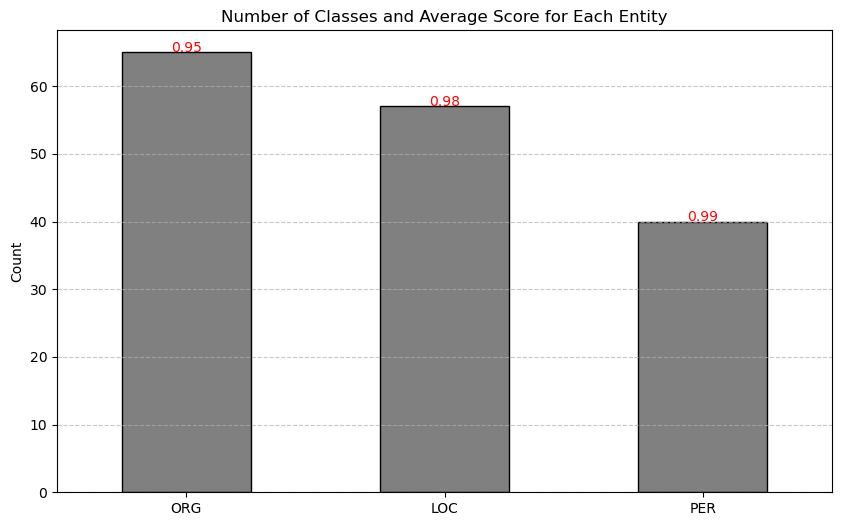

In [396]:
entity_counts = df["entity_group"].value_counts()

# Calculate average score for each entity
average_scores = df.groupby("entity_group")["score"].mean()

# Plot
plt.figure(figsize=(10, 6))
bars = entity_counts.plot(kind="bar", color="grey", edgecolor="black")
plt.title("Number of Classes and Average Score for Each Entity")
plt.xlabel("")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Average scores as annotations
for index, (entity, count) in enumerate(entity_counts.items()):
    avg_score = average_scores[entity]
    plt.text(index, count + 0.1, f"{avg_score:.2f}", ha="center", fontsize=10, color="red")
plt.show()

## Top N for each Entity

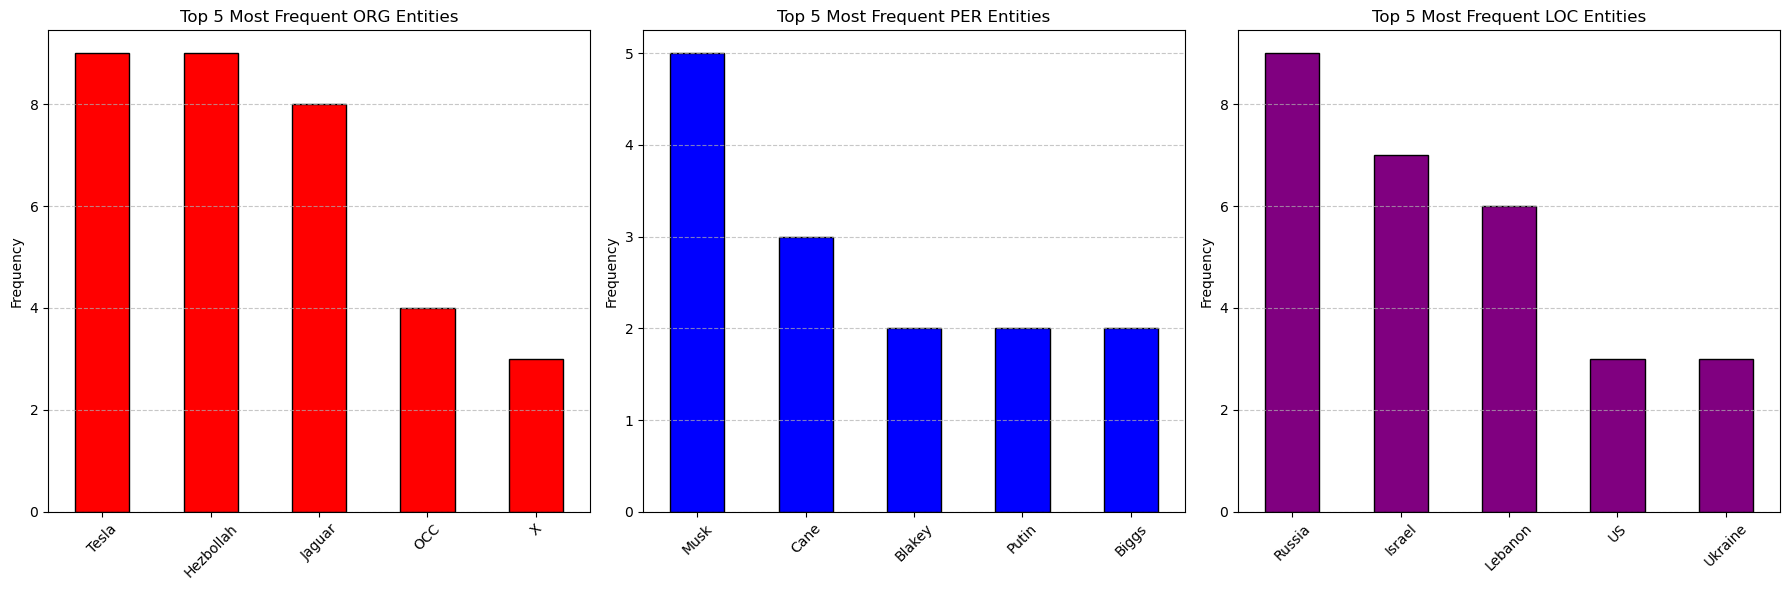

In [446]:
def plot_top_entities(df, entity_types, top_n=5):
    fig, axes = plt.subplots(1, len(entity_types), figsize=(18, 6))  
    
    # Ensure axes is a 1D array for easy iteration
    if len(entity_types) == 1:
        axes = [axes]
    
    # Iterate through each entity type and plot on corresponding axis
    for ax, entity_type in zip(axes, entity_types):
        filtered_df = df[df['entity_group'] == entity_type]
        
        # Count the frequency of each word for the given entity type
        entity_counts = filtered_df['word'].value_counts().nlargest(top_n)
        color = {'PER': 'blue', 'LOC': 'purple', 'ORG': 'red'}.get(entity_type, 'grey')
        
        # Plot on the current axis
        entity_counts.plot(kind='bar', color=color, edgecolor='black', ax=ax)
        
        # Customize the plot
        ax.set_title(f"Top {top_n} Most Frequent {entity_type} Entities")
        ax.set_xlabel("")
        ax.set_ylabel("Frequency")
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
        ax.grid(axis="y", linestyle="--", alpha=0.7)    
    plt.tight_layout()
    plt.show()

entity_types = df['entity_group'].unique()
plot_top_entities(df, entity_types, top_n=5)

## Entities Proportion by Month

In [403]:
entity_counts_by_month = df.groupby(['month', 'entity_group']).size().unstack(fill_value=0)
entity_counts_by_month

entity_group,LOC,ORG,PER
month,,,
December 2024,22,42,16
November 2024,28,15,16
October 2024,7,8,8


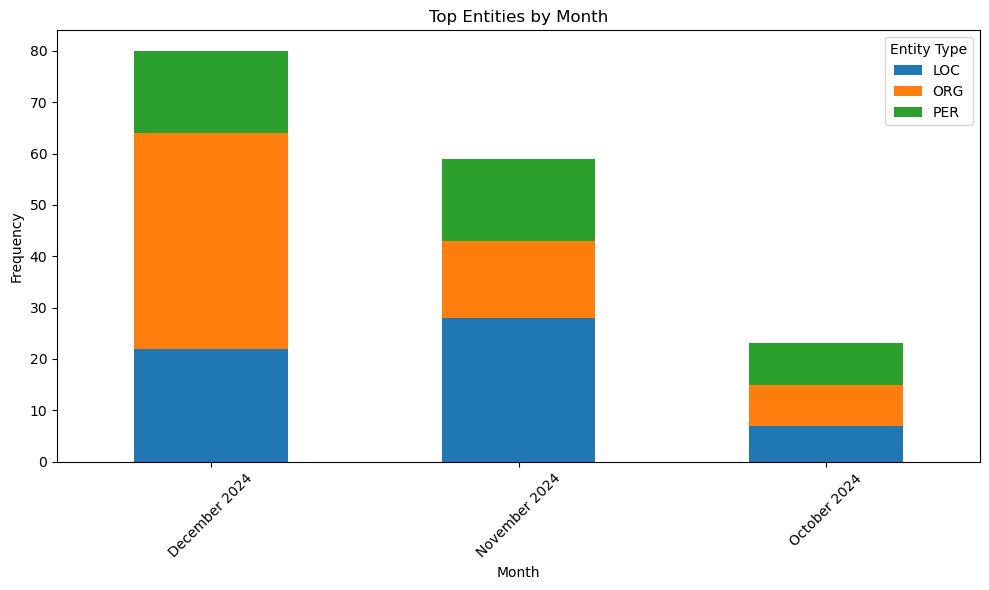

In [404]:
entity_counts_by_month.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Top Entities by Month')
plt.xlabel('Month')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend(title='Entity Type')
plt.show()

## Top Entities by Month

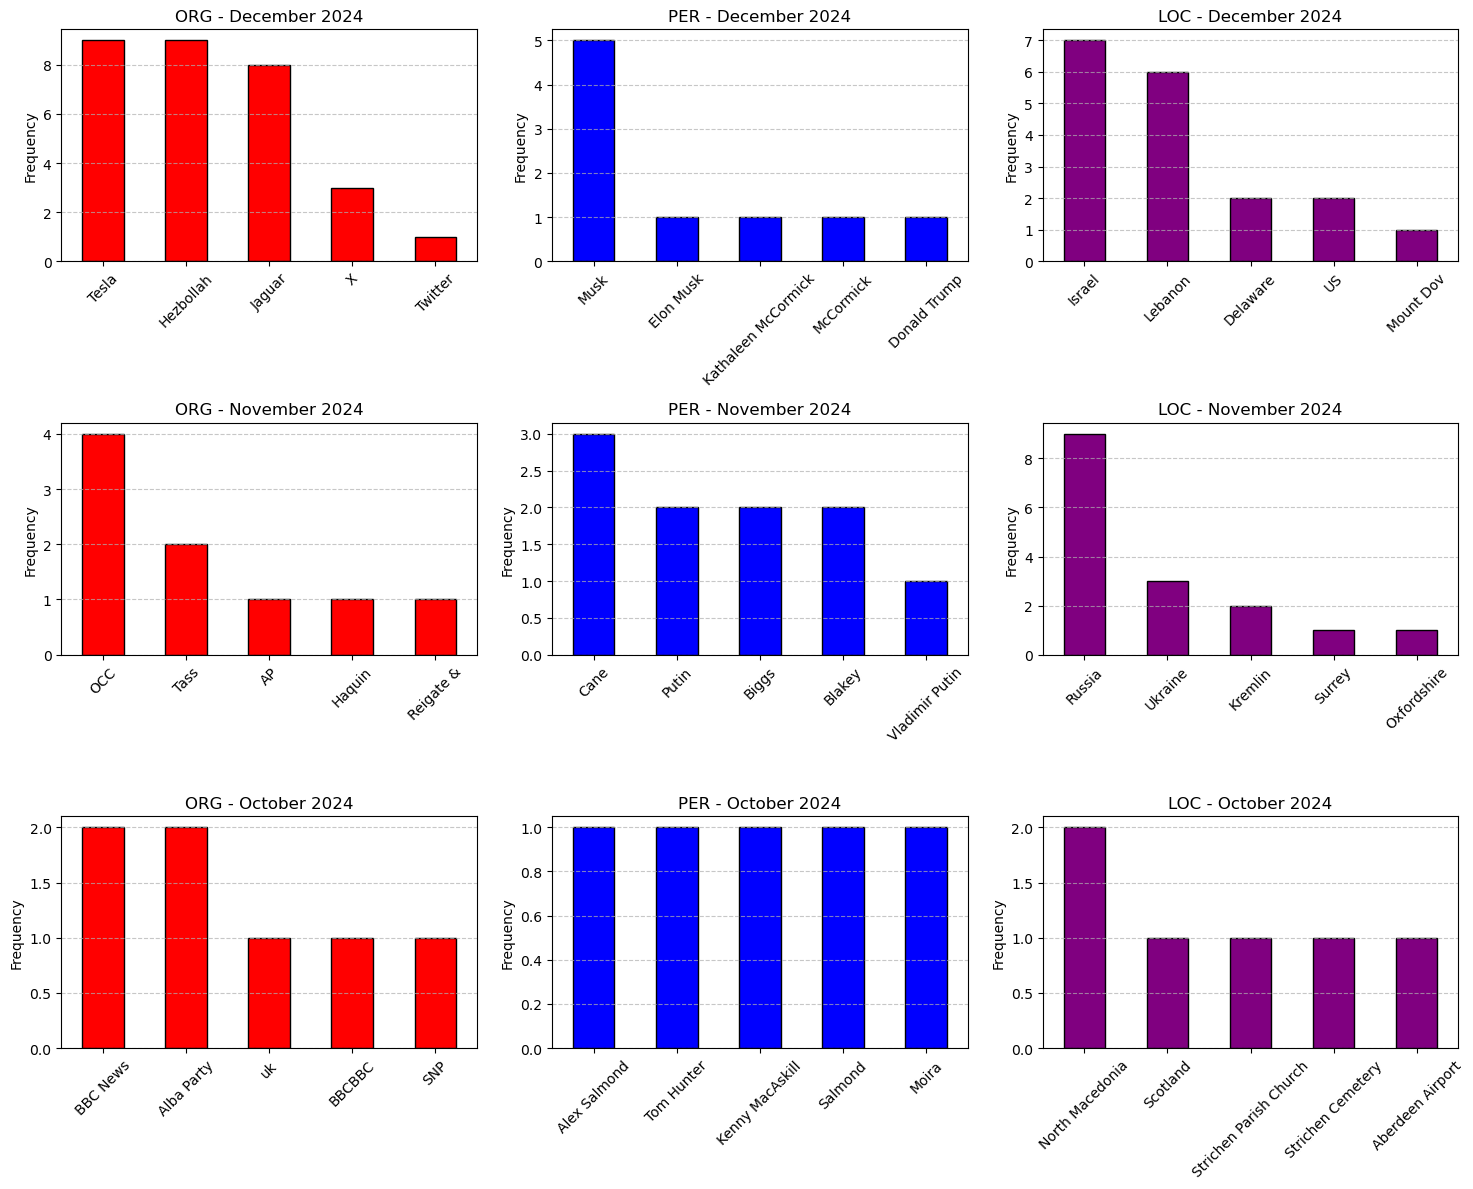

In [429]:
def plot_top_entities_per_month(df, entity_types, months, top_n=5):
    fig, axes = plt.subplots(len(months), len(entity_types), figsize=(15, 4*len(months)))
    df_filtered = df[df['month'].isin(months)]
    
    for i, month in enumerate(months):
        for j, entity_type in enumerate(entity_types):
            # Filter data for the current month and entity type
            filtered_df = df_filtered[df_filtered['entity_group'] == entity_type]
            filtered_df_month = filtered_df[filtered_df['month'] == month]

            entity_counts = filtered_df_month['word'].value_counts().nlargest(top_n)
            color = {'PER': 'blue', 'LOC': 'purple', 'ORG': 'red'}.get(entity_type, 'grey')
        
            entity_counts.plot(kind='bar', color=color, edgecolor='black', ax=axes[i, j])
            axes[i, j].set_title(f"{entity_type} - {month}")
            axes[i, j].set_ylabel('Frequency')
            axes[i, j].set_xlabel('')
            axes[i, j].grid(axis="y", linestyle="--", alpha=0.7)
            axes[i, j].set_xticklabels(axes[i, j].get_xticklabels(), rotation=45)

    plt.tight_layout()
    plt.show()

entity_types = df['entity_group'].unique()
months = df['month'].unique()
plot_top_entities_per_month(df, entity_types, months, top_n=5)

## WordCloud

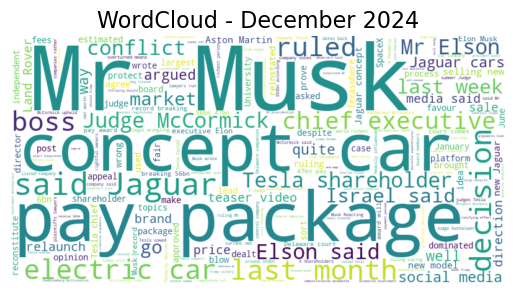

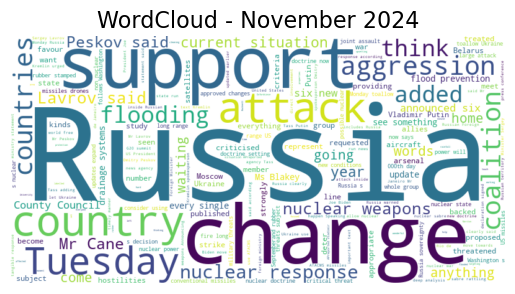

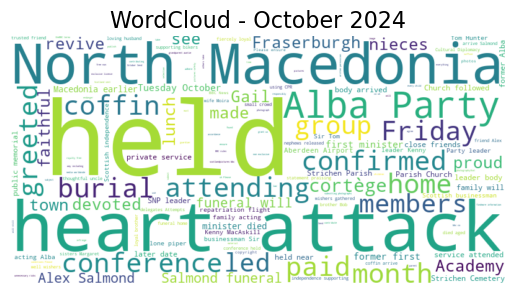

In [440]:
onths = df['month'].unique()

for i, month in enumerate(months):
    filtered_df = df[df['month'] == month]
    txt = ' '.join(filtered_df['content'])

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(txt)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"WordCloud - {month}", fontsize=16)
    plt.show()